#LLM Authorship Attribution

**Description:** This script can be used to train a BERT model and test LLM authorship attribution.

#STEP 0: Download dataset and install dependencies

In [ ]:

print("[*] Installing dependencies...")
!pip install lizard openai > /dev/null 2>&1
!pip install --upgrade transformers > /dev/null 2>&1
print("[*] Installation: DONE")
print("[*] Loading packages...")
import random, string, re, os, json, lizard, tempfile
from openai import OpenAI #opentrouter.ai
#import openai #Oritinal OpenAI
import pandas as pd
from collections import Counter
from tqdm import tqdm
from threading import Lock
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import numpy as np
print("[*] Load: DONE")
print("[*] Downloading LLM-AuthorBench dataset")
!wget -O LLM-AuthorBench.json.zip https://github.com/LLMauthorbench/LLMauthorbench/raw/main/LLM-AuthorBench.json.zip > /dev/null 2>&1
# Unzip the file
!unzip LLM-AuthorBench.json.zip > /dev/null 2>&1
# Delete the zip file
!rm LLM-AuthorBench.json.zip > /dev/null 2>&1
print("[*] Download: DONE")
# Read JSON data from file
with open('/content/LLM-AuthorBench.json', 'r') as file:
    data = json.load(file)
# Convert JSON data to DataFrame
balanced_df = pd.DataFrame(data)

[*] Installing dependencies...
[*] Installation: DONE
[*] Loading packages...
[*] Load: DONE
[*] Downloading LLM-AuthorBench dataset
[*] Download: DONE


# STEP 1: C program Distribution

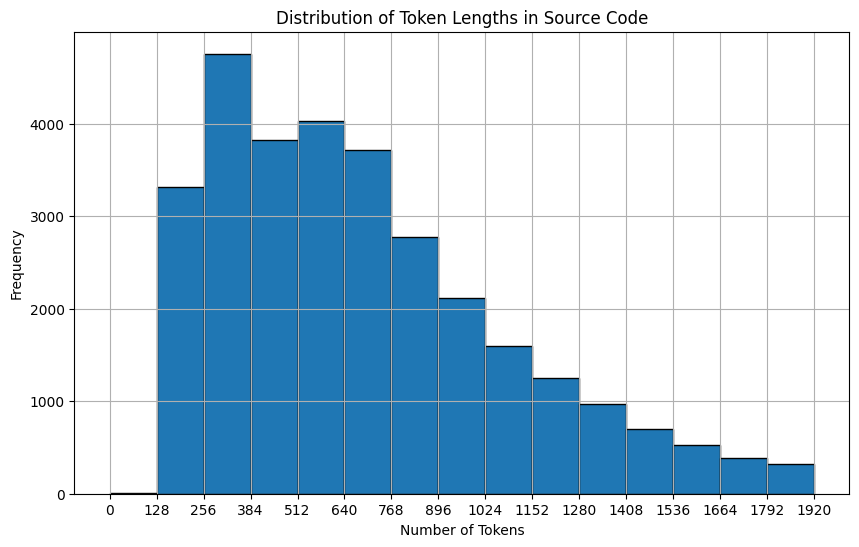

In [ ]:
distribution = balanced_df['token_size'].describe()
bins = np.arange(0, 2000, 128)
plt.figure(figsize=(10, 6))
plt.hist(balanced_df['token_size'], bins=bins, edgecolor='black')
plt.title('Distribution of Token Lengths in Source Code')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.grid(True)
plt.show()


#STEP 2: BERT training (5-class multi classification)

In [ ]:
# Download BERT model and set the training parameters
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification


encoder = LabelEncoder()

filtered_df = balanced_df[balanced_df['model_name'].isin(['gpt-4.1', 'deepseek-chat','claude-3.5-haiku','gemini-2.5-flash-preview-05-20','llama-3.3-70b-instruct'])].copy()

# Encode model names as binary labels
filtered_df['model_class'] = encoder.fit_transform(filtered_df['model_name'])

# Split the dataset (use stratify to preserve class balance)
train_df, test_df = train_test_split(filtered_df,test_size=0.2,random_state=42, stratify=filtered_df['model_class'])

# Load tokenizer and BERT model for 5-class classification
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=5)


# Define dataset class
class CSourceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
      row = self.data.iloc[index]
      prompt = str(row['prompt'])
      LLM=str(row['model_name']) #If we add this to the training it will reach 100% (because this is the target label)
      code = str(row['c_code'])
      combined_text = (f"code: {code}")

      inputs = self.tokenizer.encode_plus(
          combined_text,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          return_token_type_ids=True, # for original BERT
          truncation=True,
          return_attention_mask=True
      )

      return {
          'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
          'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
          'labels': torch.tensor(row['model_class'], dtype=torch.long)
      }

    def __len__(self):
        return len(self.data)

# Prepare datasets
train_dataset = CSourceDataset(train_df, tokenizer)
test_dataset = CSourceDataset(test_df, tokenizer)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define training arguments (remove invalid key)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    warmup_steps=200,
    weight_decay=0.01,
    report_to="none",
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    learning_rate=5e-5,
    lr_scheduler_type='cosine_with_restarts',
    warmup_ratio=0.1,
)


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
# Train the model
trainer.train()
trainer.evaluate()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.43403369188308716,
 'eval_accuracy': 0.92975,
 'eval_f1': 0.9298878365543124,
 'eval_precision': 0.9300722177653487,
 'eval_recall': 0.92975,
 'eval_runtime': 55.8241,
 'eval_samples_per_second': 71.654,
 'eval_steps_per_second': 17.913,
 'epoch': 10.0}

In [ ]:
model_path = "BERT-5-class"
model.save_pretrained(model_path)

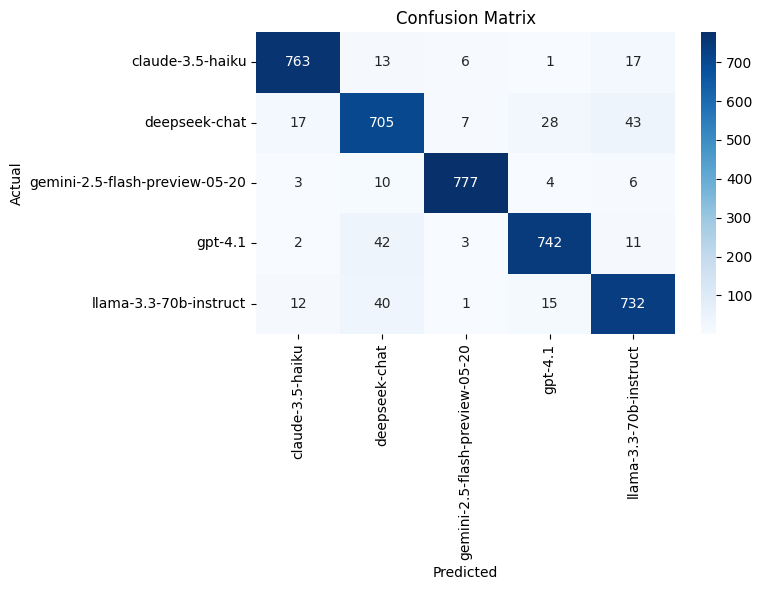

In [16]:
#Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from the trainer
predictions = trainer.predict(test_dataset)

# Extract predicted labels
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Get class names from the LabelEncoder
encoder = LabelEncoder()
encoder.fit(filtered_df['model_name'])  # or use the original encoder if stored

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.pdf')
plt.show()


#STEP 3: Test the newly created BERT model using OpenAI API

In [19]:
import torch
from transformers import BertForSequenceClassification

def extract_code(result: str) -> str:
    patterns = [
        r"```c\s*([\s\S]*?)\s*```",
        r"```C\s*([\s\S]*?)\s*```",
        r"c```\s*([\s\S]*?)\s*```",
        r"C```C\s*([\s\S]*?)\s*```",
        r"```\s*([\s\S]*?)\s*```"
    ]
    for pattern in patterns:
        match = re.search(pattern, result)
        if match:
            return match.group(1).strip()
    return result.strip()

def predict_c_code_category(code_str, model, tokenizer, encoder):
    # Tokenize the code
    encoded = tokenizer.encode_plus(
        code_str,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True
    )

    # Prepare tensors
    input_ids = torch.tensor(encoded['input_ids'], dtype=torch.long).unsqueeze(0)
    attention_mask = torch.tensor(encoded['attention_mask'], dtype=torch.long).unsqueeze(0)

    # Inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]
        predicted_label = torch.argmax(logits, dim=1).item()
        predicted_category = encoder.inverse_transform([predicted_label])[0]
        confidence = float(probabilities[predicted_label])

    return predicted_category, confidence


# New C code sample (can be from a generator, user input, etc.)
loaded_model = BertForSequenceClassification.from_pretrained(model_path)
loaded_model.eval()  # Set to eval mode for inference


#Test our new BERT model!
from openai import OpenAI
api_key = "<Your OpenAI API key to test the new model>"  # Your actual OpenAI key
client = OpenAI(api_key=api_key)
model_prediction="gpt-4.1"
prompt="Create me a C program that show me a human DNS'"
response = client.chat.completions.create(model=model_prediction, messages=[{"role": "user", "content": prompt}],)
content = response.choices[0].message.content
c_code = extract_code(content)
print(c_code)


# Run prediction
category, confidence = predict_c_code_category(c_code, loaded_model, tokenizer, encoder)
print("Predicted Category:", category)
print(f"Confidence Level: {confidence:.2f}")



#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <netdb.h>
#include <arpa/inet.h>
#include <sys/socket.h>

int main(int argc, char *argv[]) {
    char hostname[256];

    // Get the hostname from arguments or ask user
    if (argc < 2) {
        printf("Enter a human DNS (domain name): ");
        if (scanf("%255s", hostname) != 1) {
            fprintf(stderr, "Input error.\n");
            return 1;
        }
    } else {
        strncpy(hostname, argv[1], sizeof(hostname));
        hostname[sizeof(hostname)-1] = '\0';
    }

    struct addrinfo hints, *res, *p;
    int status;

    memset(&hints, 0, sizeof hints);
    hints.ai_family = AF_UNSPEC; // AF_INET or AF_INET6 to force version
    hints.ai_socktype = SOCK_STREAM;

    if ((status = getaddrinfo(hostname, NULL, &hints, &res)) != 0) {
        fprintf(stderr, "getaddrinfo: %s\n", gai_strerror(status));
        return 2;
    }

    printf("IP addresses for %s:\n", hostname);

    char ipstr[INET6_ADDRSTRLEN];
